In [358]:
import pandas as pd
import pickle
from scipy.stats import poisson

In [359]:
negara_pergrup = pickle.load(open('/Users/agagoks/Desktop/Predicting Worldcup 2022/file/fifa-world-cup-2022-prediction-main/data/dict_table','rb'))
df_goals = pd.read_csv('/Users/agagoks/Desktop/Predicting Worldcup 2022/file/fifa-world-cup-2022-prediction-main/data/clean_fifa_worldcup_matches.csv')
df_fixture = pd.read_csv('/Users/agagoks/Desktop/Predicting Worldcup 2022/file/fifa-world-cup-2022-prediction-main/data/clean_fifa_worldcup_fixture.csv')

## 1. Hitung Kekuatan Tim

In [360]:
#Pisahin satu persatu buat Data Gol masing-masing Tim Negara
tabel_kandang = df_goals[['HomeTeam','HomeGoals','AwayGoals']]
tabel_tandang = df_goals[['AwayTeam','HomeGoals','AwayGoals']]
print(tabel_kandang)
print(tabel_tandang)

      HomeTeam  HomeGoals  AwayGoals
0       France          4          1
1      Uruguay          4          2
2      Uruguay          6          1
3    Argentina          6          1
4     Paraguay          1          0
..         ...        ...        ...
895     Brazil          2          0
896     Serbia          1          2
897     Serbia          0          2
898     France          1          0
899     Brazil          1          2

[900 rows x 3 columns]
          AwayTeam  HomeGoals  AwayGoals
0           Mexico          4          1
1        Argentina          4          2
2       Yugoslavia          6          1
3    United States          6          1
4          Belgium          1          0
..             ...        ...        ...
895     Costa Rica          2          0
896    Switzerland          1          2
897         Brazil          0          2
898           Peru          1          0
899        Belgium          1          2

[900 rows x 3 columns]


In [361]:
#Rename Nama Kolom Tabel Gol
tabel_kandang = tabel_kandang.rename(columns={'HomeTeam':'TimNegara','HomeGoals':'Gol','AwayGoals':'GolKebobolan'})
tabel_tandang = tabel_tandang.rename(columns={'AwayTeam':'TimNegara','HomeGoals':'GolKebobolan','AwayGoals':'Gol'})
print(tabel_kandang)
print(tabel_tandang)

     TimNegara  Gol  GolKebobolan
0       France    4             1
1      Uruguay    4             2
2      Uruguay    6             1
3    Argentina    6             1
4     Paraguay    1             0
..         ...  ...           ...
895     Brazil    2             0
896     Serbia    1             2
897     Serbia    0             2
898     France    1             0
899     Brazil    1             2

[900 rows x 3 columns]
         TimNegara  GolKebobolan  Gol
0           Mexico             4    1
1        Argentina             4    2
2       Yugoslavia             6    1
3    United States             6    1
4          Belgium             1    0
..             ...           ...  ...
895     Costa Rica             2    0
896    Switzerland             1    2
897         Brazil             0    2
898           Peru             1    0
899        Belgium             1    2

[900 rows x 3 columns]


In [362]:
tabel_kekuatantim = pd.concat([tabel_kandang,tabel_tandang],ignore_index=True).groupby('TimNegara').mean()
tabel_kekuatantim

,Gol,GolKebobolan
TimNegara,,
Algeria,1.000000,1.461538
Angola,0.333333,0.666667
Argentina,1.691358,1.148148
Australia,0.812500,1.937500
Austria,1.482759,1.620690
...,...,...
Uruguay,1.553571,1.321429
Wales,0.800000,0.800000
West Germany,2.112903,1.241935


## 2. Bikin Function Prediksi Poin

In [363]:
def prediksi_poin(kandang, tandang):
    if kandang in tabel_kekuatantim.index and tandang in tabel_kekuatantim.index:
        # gol * golkebobolan
        lambda_kandang = tabel_kekuatantim.at[kandang,'Gol'] * tabel_kekuatantim.at[tandang,'GolKebobolan']
        lambda_tandang = tabel_kekuatantim.at[tandang,'Gol'] * tabel_kekuatantim.at[kandang,'GolKebobolan']
        peluang_kandang, peluang_tandang, peluang_seri = 0, 0, 0
        for x in range(0,11): #jumlah gol di kandang
            for y in range(0, 11): #jumlah gol di tandang
                p = poisson.pmf(x, lambda_kandang) * poisson.pmf(y, lambda_tandang)
                if x == y:
                    peluang_seri += p
                elif x > y:
                    peluang_kandang += p
                else:
                    peluang_tandang += p
        
        poin_kandang = 3 * peluang_kandang + peluang_seri
        poin_tandang = 3 * peluang_tandang + peluang_seri
        return (poin_kandang, poin_tandang)
    else:
        return (0, 0)

## 3. Prediksi pakai Function yang sudah dibuat

In [364]:
print(prediksi_poin('Argentina','Mexico'))
print(prediksi_poin('France','Tunisia'))
print(prediksi_poin('Japan','Germany'))
print(prediksi_poin('Brazil','Cameroon'))
print(prediksi_poin('Portugal','Ghana'))
print(prediksi_poin('Brazil','Germany'))

(2.3129151525530505, 0.5378377125059863)
(2.4593706967067446, 0.4099298842555182)
(0.4564917304513103, 2.398798931491757)
(2.766788040790599, 0.16070278218467365)
(1.948655324046039, 0.8484267835008392)
(1.5116745114853647, 1.2846784356494922)


## 4. Bikin Jadwal Tanding per Fase

In [365]:
#Cari Jadwal Per Fase

##Jadi fase Grup ada 8 grup/32 tim x 6 jatah main = 48 pertandingan
tabel_jadwal_grup = df_fixture[:48].copy()
##Lanjut fase Knockout/Playoff ada 8 pertandingan
tabel_jadwal_knockout = df_fixture[48:56].copy()
##Fase 1/4 ada 4 pertandingan
tabel_jadwal_seperempat = df_fixture[56:60].copy()
##Fase Semifinal ada 2 pertandingan
tabel_jadwal_semifinal = df_fixture[60:62].copy()
##Fase Final ada 1 pertandingan, sekaligus perebutan juara ke-3 berarti ada 1 pertandingan
tabel_jadwal_final = df_fixture[62:].copy()
##Total pertandingan berjumlah 48 + 8 + 4 + 2 + 1 + 1 = 64 pertandingan

print('Fase Grup')
print(tabel_jadwal_grup)
print('Fase Knockout')
print(tabel_jadwal_knockout)
print('Fase 1/4 Final')
print(tabel_jadwal_seperempat)
print('Fase Semifinal')
print(tabel_jadwal_semifinal)
print('Fase Final')
print(tabel_jadwal_final)

Fase Grup
             home     score           away  year
0           Qatar   Match 1        Ecuador  2022
1         Senegal   Match 2    Netherlands  2022
2           Qatar  Match 18        Senegal  2022
3     Netherlands  Match 19        Ecuador  2022
4         Ecuador  Match 35        Senegal  2022
5     Netherlands  Match 36          Qatar  2022
6         England   Match 3           Iran  2022
7   United States   Match 4          Wales  2022
8           Wales  Match 17           Iran  2022
9         England  Match 20  United States  2022
10          Wales  Match 33        England  2022
11           Iran  Match 34  United States  2022
12      Argentina   Match 8   Saudi Arabia  2022
13         Mexico   Match 7         Poland  2022
14         Poland  Match 22   Saudi Arabia  2022
15      Argentina  Match 24         Mexico  2022
16         Poland  Match 39      Argentina  2022
17   Saudi Arabia  Match 40         Mexico  2022
18        Denmark   Match 6        Tunisia  2022
19        

## 5. Fase Grup

In [366]:
for grup in negara_pergrup:
    tabel_negara = negara_pergrup[grup]['Team'].values #4 negara dalam 1 grup
    fixture_6match_pergrup = tabel_jadwal_grup[tabel_jadwal_grup['home'].isin(tabel_negara)] #antarnegara 6x main
    for index,row in fixture_6match_pergrup.iterrows():
        kandang,tandang = row['home'], row['away']
        poin_kandang,poin_tandang = prediksi_poin(kandang,tandang)
        negara_pergrup[grup].loc[negara_pergrup[grup]['Team'] == kandang, 'Pts'] += poin_kandang
        negara_pergrup[grup].loc[negara_pergrup[grup]['Team'] == tandang, 'Pts'] += poin_tandang
            
    negara_pergrup[grup] = negara_pergrup[grup].sort_values('Pts', ascending=False).reset_index()
    negara_pergrup[grup] = negara_pergrup[grup][['Team','Pts']]
    negara_pergrup[grup] = negara_pergrup[grup].round(0)

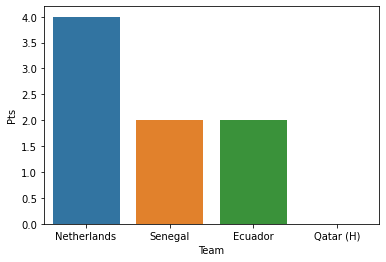

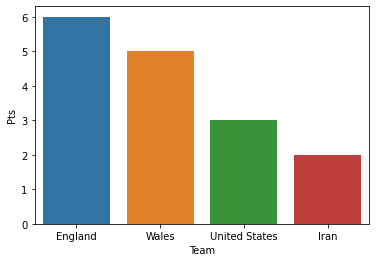

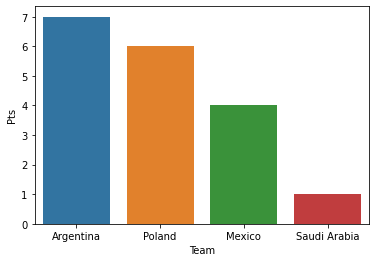

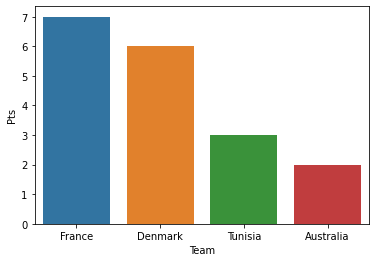

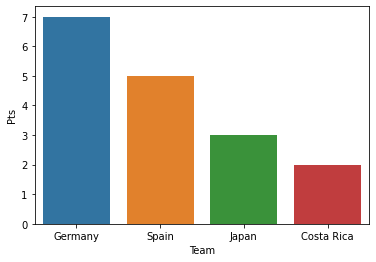

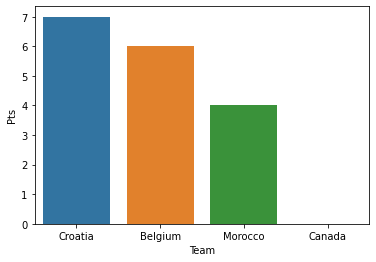

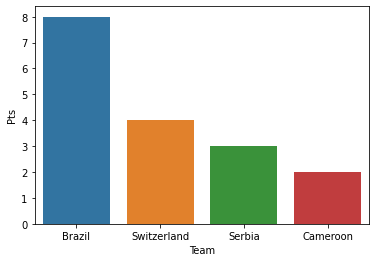

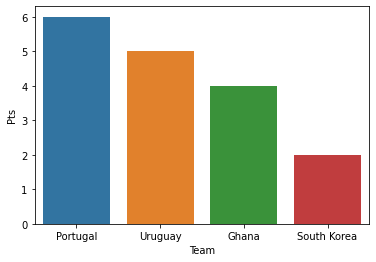

In [367]:
import seaborn as sns
import matplotlib.pyplot as plt

df_grupA = pd.DataFrame(negara_pergrup['Group A'])
sns.barplot(x='Team',y='Pts',data=df_grupA)
plt.show()

df_grupB = pd.DataFrame(negara_pergrup['Group B'])
sns.barplot(x='Team',y='Pts',data=df_grupB)
plt.show()

df_grupC = pd.DataFrame(negara_pergrup['Group C'])
sns.barplot(x='Team',y='Pts',data=df_grupC)
plt.show()

df_grupD = pd.DataFrame(negara_pergrup['Group D'])
sns.barplot(x='Team',y='Pts',data=df_grupD)
plt.show()

df_grupE = pd.DataFrame(negara_pergrup['Group E'])
sns.barplot(x='Team',y='Pts',data=df_grupE)
plt.show()

df_grupF = pd.DataFrame(negara_pergrup['Group F'])
sns.barplot(x='Team',y='Pts',data=df_grupF)
plt.show()

df_grupG = pd.DataFrame(negara_pergrup['Group G'])
sns.barplot(x='Team',y='Pts',data=df_grupG)
plt.show()

df_grupH = pd.DataFrame(negara_pergrup['Group H'])
sns.barplot(x='Team',y='Pts',data=df_grupH)
plt.show()

## 6. Fase Knockout

In [368]:
tabel_jadwal_knockout

,home,score,away,year
48,Winners Group A,Match 49,Runners-up Group B,2022
49,Winners Group C,Match 50,Runners-up Group D,2022
50,Winners Group D,Match 52,Runners-up Group C,2022
51,Winners Group B,Match 51,Runners-up Group A,2022
52,Winners Group E,Match 53,Runners-up Group F,2022
53,Winners Group G,Match 54,Runners-up Group H,2022
54,Winners Group F,Match 55,Runners-up Group E,2022
55,Winners Group H,Match 56,Runners-up Group G,2022


In [369]:
for grup in negara_pergrup:
    pemenang1_grup = negara_pergrup[grup].loc[0, 'Team']
    pemenang2_grup = negara_pergrup[grup].loc[1, 'Team']
    tabel_jadwal_knockout.replace({f'Winners {grup}':pemenang1_grup,
                                 f'Runners-up {grup}':pemenang2_grup}, inplace=True)

tabel_jadwal_knockout['winner'] = '?'
tabel_jadwal_knockout

,home,score,away,year,winner
48,Netherlands,Match 49,Wales,2022,?
49,Argentina,Match 50,Denmark,2022,?
50,France,Match 52,Poland,2022,?
51,England,Match 51,Senegal,2022,?
52,Germany,Match 53,Belgium,2022,?
53,Brazil,Match 54,Uruguay,2022,?
54,Croatia,Match 55,Spain,2022,?
55,Portugal,Match 56,Switzerland,2022,?


In [370]:
def cari_pemenang(jadwal_terbaru):
    for index, row in jadwal_terbaru.iterrows():
        kandang, tandang = row['home'], row['away']
        poin_kandang, poin_tandang = prediksi_poin(kandang, tandang)
        if poin_kandang > poin_tandang:
            pemenang = kandang
        else:
            pemenang = tandang
        jadwal_terbaru.loc[index, 'winner'] = pemenang
    return jadwal_terbaru

In [371]:
cari_pemenang(tabel_jadwal_knockout)

,home,score,away,year,winner
48,Netherlands,Match 49,Wales,2022,Netherlands
49,Argentina,Match 50,Denmark,2022,Argentina
50,France,Match 52,Poland,2022,France
51,England,Match 51,Senegal,2022,England
52,Germany,Match 53,Belgium,2022,Germany
53,Brazil,Match 54,Uruguay,2022,Brazil
54,Croatia,Match 55,Spain,2022,Spain
55,Portugal,Match 56,Switzerland,2022,Portugal


## 7. Kuarter-Final

In [372]:
tabel_jadwal_seperempat

,home,score,away,year
56,Winners Match 53,Match 58,Winners Match 54,2022
57,Winners Match 49,Match 57,Winners Match 50,2022
58,Winners Match 55,Match 60,Winners Match 56,2022
59,Winners Match 51,Match 59,Winners Match 52,2022


In [373]:
def update_tabel(kuarter_ronde1, kuarter_ronde2):
    for index, row in kuarter_ronde1.iterrows():
        pemenang = kuarter_ronde1.loc[index, 'winner']
        pertandingan = kuarter_ronde1.loc[index, 'score']
        kuarter_ronde2.replace({f'Winners {pertandingan}':pemenang}, inplace=True)
    kuarter_ronde2['winner'] = '?'
    return kuarter_ronde2

In [374]:
update_tabel(tabel_jadwal_knockout, tabel_jadwal_seperempat)

,home,score,away,year,winner
56,Germany,Match 58,Brazil,2022,?
57,Netherlands,Match 57,Argentina,2022,?
58,Spain,Match 60,Portugal,2022,?
59,England,Match 59,France,2022,?


In [375]:
cari_pemenang(tabel_jadwal_seperempat)

,home,score,away,year,winner
56,Germany,Match 58,Brazil,2022,Brazil
57,Netherlands,Match 57,Argentina,2022,Netherlands
58,Spain,Match 60,Portugal,2022,Portugal
59,England,Match 59,France,2022,France


## 8. Semi-Final

In [376]:
update_tabel(tabel_jadwal_seperempat,tabel_jadwal_semifinal)

,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,?
61,France,Match 62,Portugal,2022,?


In [377]:
cari_pemenang(tabel_jadwal_semifinal)

,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,Brazil
61,France,Match 62,Portugal,2022,France


## 9. Final

In [379]:
update_tabel(tabel_jadwal_semifinal,tabel_jadwal_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,?
63,Brazil,Match 64,France,2022,?


In [380]:
cari_pemenang(tabel_jadwal_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,Losers Match 62
63,Brazil,Match 64,France,2022,Brazil
